<a href="https://colab.research.google.com/github/rallm/IUST-DL-Fall2025/blob/main/HW2/Practical/Model_selection_regularization_dropout_label_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

Using device: cuda



# Load Fashion-MNIST dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Specify the mean and standard deviation for Fashion-MNIST normalization.
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.1MB/s]


In [4]:
# Use a fraction of the training set to induce overfitting.
train_size = len(train_dataset) // 7
train_indices = torch.randperm(len(train_dataset))[:train_size].tolist()
train_subset = Subset(train_dataset, train_indices)

# Create the DataLoader for the training subset

In [5]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader =  DataLoader(test_dataset, batch_size=1000, shuffle=False)

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Dataset: Fashion-MNIST")
print(f"Training samples: {len(train_subset)} (~15% of full dataset)")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {', '.join(class_names)}\n")

Dataset: Fashion-MNIST
Training samples: 8571 (~15% of full dataset)
Test samples: 10000
Classes: T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot



# 1. COMPLEX MODEL (prone to overfitting)

In [6]:
class ComplexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2. SIMPLE MODEL (model selection)

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. MODEL WITH DROPOUT

In [8]:
class ModelWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# 4. LABEL SMOOTHING LOSS

In [9]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, n_classes=10, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.n_classes = n_classes
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        log_probs = torch.log_softmax(pred, dim=1)
        # Create the smoothed label distribution.
        smooth_labels = torch.zeros_like(pred)
        # Fill the smoothed labels tensor.
        smooth_labels.fill_(self.smoothing / self.n_classes)
        # Set the confidence value for the correct class.
        smooth_labels.scatter_(1, target.unsqueeze(1), self.confidence + self.smoothing / self.n_classes)
        # Calculate the final smoothed loss.
        loss = -torch.sum(smooth_labels * log_probs, dim=1)
        return loss.mean()

# Training and evaluation functions

In [10]:
def train_epoch(model, loader, criterion, optimizer, device, l1_lambda=0.0):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Zero out the gradients.
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Add L1 regularization if specified.
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

        # Perform backpropagation.
        loss.backward()
        # Update the model weights.
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        # count number of correct predictions
        correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            # Get the predicted classes from the outputs.
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # Calculate the number of correct predictions.
            correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total


def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20, l1_lambda=0.0):
    model = model.to(device)
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        # Call the training and evaluation functions for one epoch.
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, l1_lambda)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        if (epoch + 1) % 4 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print(f"  Overfitting Gap: {train_acc - test_acc:.2f}%")

    return train_losses, test_losses, train_accs, test_accs

#Experiments

In [11]:
# Dictionary to store all results
results = {}

# Experiment 1: Complex model without regularization
print("=" * 70)
print("EXPERIMENT 1: Complex Model (No Regularization)")
print("=" * 70)
model1 = ComplexModel()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
results['Complex (No Reg)'] = train_model(model1, train_loader, test_loader, criterion1, optimizer1)

# Experiment 2: Simple model (Model Selection)
print("\n" + "=" * 70)
print("EXPERIMENT 2: Simple Model (Model Selection)")
print("=" * 70)
model2 = SimpleModel()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
results['Simple Model'] = train_model(model2, train_loader, test_loader, criterion2, optimizer2)

# Experiment 3: Complex model with Dropout
print("\n" + "=" * 70)
print("EXPERIMENT 3: Complex Model with Dropout (rate=0.5)")
print("=" * 70)
# Instantiate the model with a specified dropout rate.
model3 = ModelWithDropout(dropout_rate=0.5)
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
results['Complex + Dropout'] = train_model(model3, train_loader, test_loader, criterion3, optimizer3)

# Experiment 4: Complex model with L1 Regularization
print("\n" + "=" * 70)
print("EXPERIMENT 4: Complex Model with L1 Regularization (λ=0.0001)")
print("=" * 70)
model4 = ComplexModel()
criterion4 = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
# Train the model, passing the L1 lambda value.
results['Complex + L1'] = train_model(model4, train_loader, test_loader, criterion4, optimizer4, l1_lambda=0.0001)

# Experiment 5: Complex model with L2 Regularization
print("\n" + "=" * 70)
print("EXPERIMENT 5: Complex Model with L2 Regularization (λ=0.01)")
print("=" * 70)
model5 = ComplexModel()
criterion5 = nn.CrossEntropyLoss()
# Add L2 regularization (weight_decay) to the optimizer.
optimizer5 = optim.Adam(model5.parameters(), lr=0.001, weight_decay=0.01)
results['Complex + L2'] = train_model(model5, train_loader, test_loader, criterion5, optimizer5)

# Experiment 6: Complex model with Label Smoothing
print("\n" + "=" * 70)
print("EXPERIMENT 6: Complex Model with Label Smoothing (ε=0.1)")
print("=" * 70)
model6 = ComplexModel()
# Use the custom Label Smoothing loss function.
criterion6 = LabelSmoothingCrossEntropy(n_classes=10, smoothing=0.1)
optimizer6 = optim.Adam(model6.parameters(), lr=0.001)
results['Complex + Label Smoothing'] = train_model(model6, train_loader, test_loader, criterion6, optimizer6)

# Experiment 7: L1 + L2 (Elastic Net)
print("\n" + "=" * 70)
print("EXPERIMENT 7: Complex Model with L1 + L2 (Elastic Net)")
print("=" * 70)
model7 = ComplexModel()
criterion7 = nn.CrossEntropyLoss()
# Add L2 regularization to the optimizer.
optimizer7 = optim.Adam(model7.parameters(), lr=0.001, weight_decay=0.01)
# Train the model, passing the L1 lambda value as well.
results['Complex + L1 + L2'] = train_model(model7, train_loader, test_loader, criterion7, optimizer7, l1_lambda=0.0001)

# Experiment 8: Combined approach (Best practices)
print("\n" + "=" * 70)
print("EXPERIMENT 8: Combined (Dropout + L2 + Label Smoothing)")
print("=" * 70)
model8 = ModelWithDropout(dropout_rate=0.3)
criterion8 = LabelSmoothingCrossEntropy(n_classes=10, smoothing=0.1)
optimizer8 = optim.Adam(model8.parameters(), lr=0.001, weight_decay=0.01)
results['Combined'] = train_model(model8, train_loader, test_loader, criterion8, optimizer8)

EXPERIMENT 1: Complex Model (No Regularization)
Epoch 4/20
  Train Loss: 0.2682, Train Acc: 90.01%
  Test Loss: 0.3499, Test Acc: 87.32%
  Overfitting Gap: 2.69%
Epoch 8/20
  Train Loss: 0.1380, Train Acc: 94.83%
  Test Loss: 0.3710, Test Acc: 87.91%
  Overfitting Gap: 6.92%
Epoch 12/20
  Train Loss: 0.0754, Train Acc: 97.18%
  Test Loss: 0.4324, Test Acc: 88.26%
  Overfitting Gap: 8.92%
Epoch 16/20
  Train Loss: 0.0334, Train Acc: 98.83%
  Test Loss: 0.5597, Test Acc: 88.48%
  Overfitting Gap: 10.35%
Epoch 20/20
  Train Loss: 0.0319, Train Acc: 98.76%
  Test Loss: 0.5092, Test Acc: 88.70%
  Overfitting Gap: 10.06%

EXPERIMENT 2: Simple Model (Model Selection)
Epoch 4/20
  Train Loss: 0.3708, Train Acc: 86.31%
  Test Loss: 0.4282, Test Acc: 84.82%
  Overfitting Gap: 1.49%
Epoch 8/20
  Train Loss: 0.2713, Train Acc: 90.06%
  Test Loss: 0.3875, Test Acc: 86.14%
  Overfitting Gap: 3.92%
Epoch 12/20
  Train Loss: 0.1999, Train Acc: 92.64%
  Test Loss: 0.3964, Test Acc: 86.58%
  Overfitting

# Plot results


✓ Plot saved as 'fashion_mnist_regularization_comparison.png'


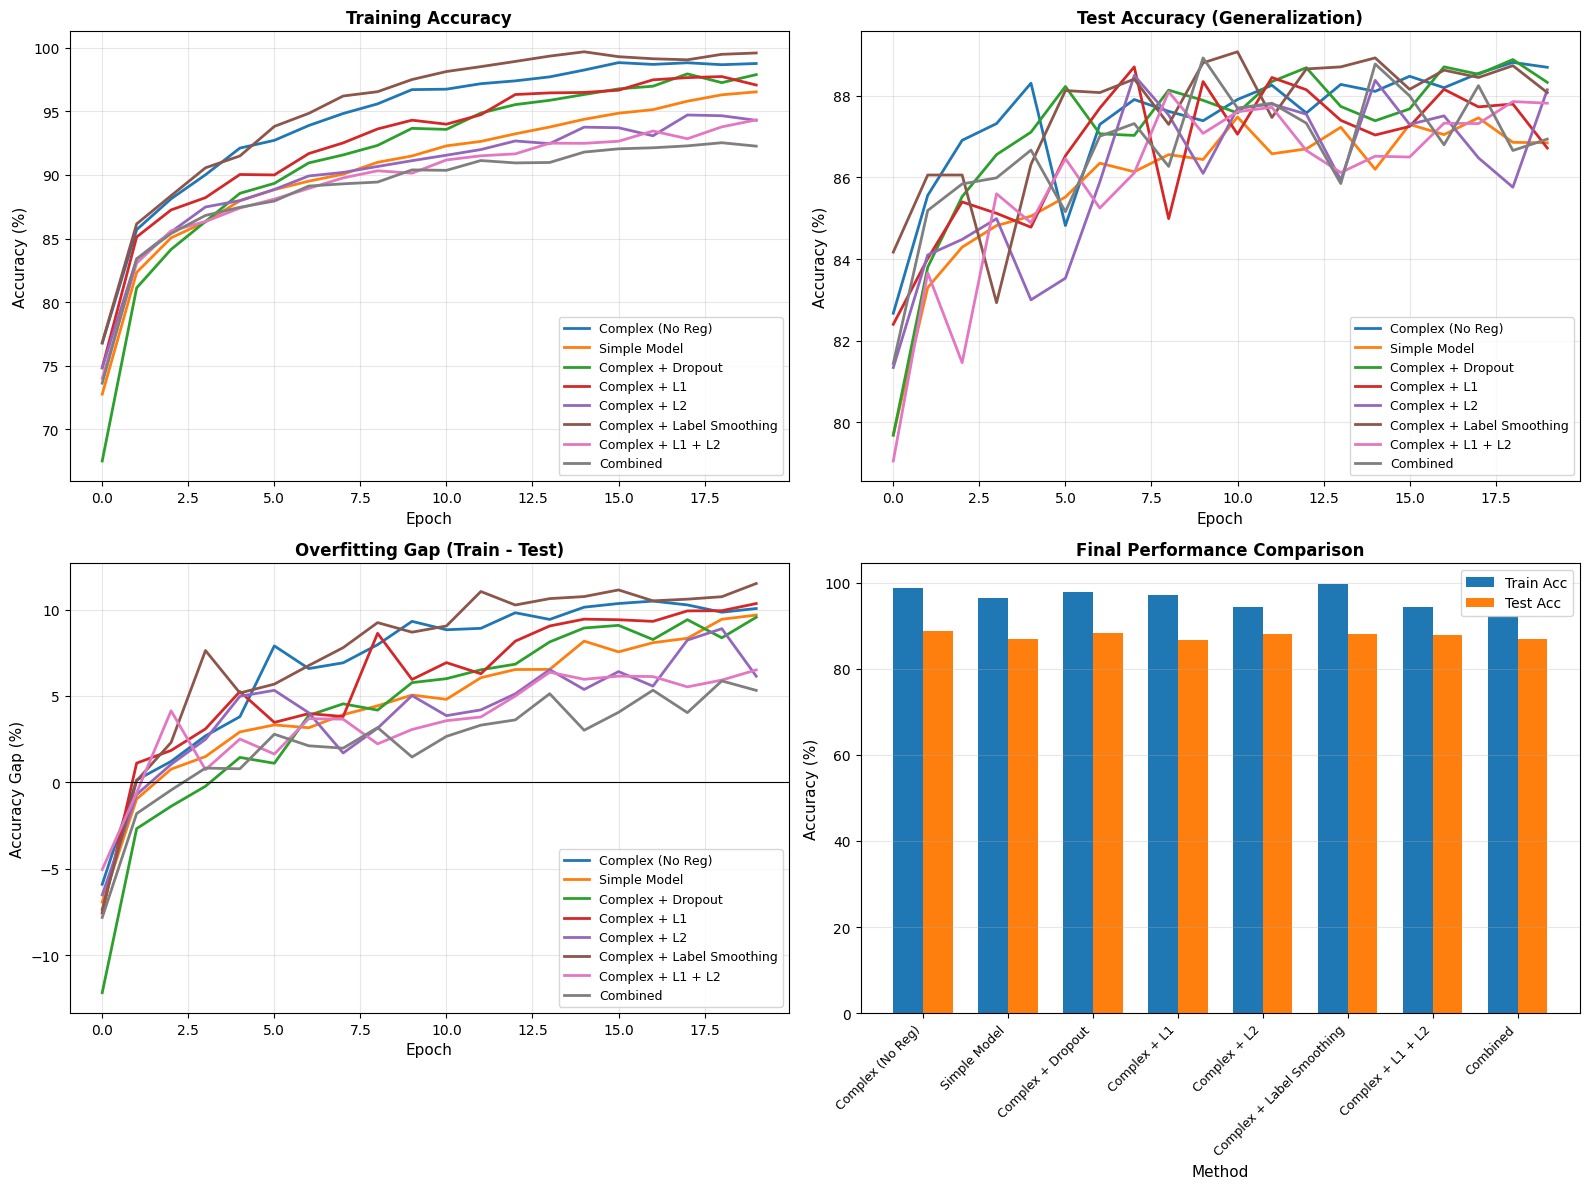

In [12]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Accuracy
for name, (_, _, train_accs, _) in results.items():
    axes[0, 0].plot(train_accs, label=name, linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 0].set_title('Training Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Accuracy
for name, (_, _, _, test_accs) in results.items():
    axes[0, 1].plot(test_accs, label=name, linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 1].set_title('Test Accuracy (Generalization)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overfitting Gap
for name, (_, _, train_accs, test_accs) in results.items():
    # Calculate the gap between training and test accuracy for each epoch.
    gap = np.array(train_accs) - np.array(test_accs)
    axes[1, 0].plot(gap, label=name, linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy Gap (%)', fontsize=11)
axes[1, 0].set_title('Overfitting Gap (Train - Test)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Plot 4: Final Performance Comparison
names = list(results.keys())
final_train = [results[name][2][-1] for name in names]
final_test = [results[name][3][-1] for name in names]
x = np.arange(len(names))
width = 0.35

# Create the bar plot for final train and test accuracies.
bars1 = axes[1, 1].bar(x - width/2, final_train, width, label='Train Acc')
bars2 = axes[1, 1].bar(x + width/2, final_test, width, label='Test Acc')

axes[1, 1].set_xlabel('Method', fontsize=11)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1, 1].set_title('Final Performance Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(names, rotation=45, ha='right', fontsize=9)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fashion_mnist_regularization_comparison.png', dpi=150, bbox_inches='tight')
print("\n✓ Plot saved as 'fashion_mnist_regularization_comparison.png'")

# Summary

In [13]:
# Summary
print("\n" + "=" * 70)
print("FINAL RESULTS SUMMARY (Fashion-MNIST)")
print("=" * 70)
print(f"{'Method':<30} | {'Train':<8} | {'Test':<8} | {'Gap':<8} | Params")
print("-" * 70)
for name, (_, _, train_accs, test_accs) in results.items():
    final_train = train_accs[-1]
    final_test = test_accs[-1]
    gap = final_train - final_test
    print(f"{name:<30} | {final_train:5.2f}% | {final_test:5.2f}% | {gap:5.2f}% |")

# Best model analysis
best_test = max(results.items(), key=lambda x: x[1][3][-1])
best_gap = min(results.items(), key=lambda x: x[1][2][-1] - x[1][3][-1])

print("\n" + "=" * 70)
print("ANALYSIS")
print("=" * 70)
print(f"Best Test Accuracy: {best_test[0]} ({best_test[1][3][-1]:.2f}%)")
print(f"Smallest Overfitting Gap: {best_gap[0]} ({best_gap[1][2][-1] - best_gap[1][3][-1]:.2f}%)")


FINAL RESULTS SUMMARY (Fashion-MNIST)
Method                         | Train    | Test     | Gap      | Params
----------------------------------------------------------------------
Complex (No Reg)               | 98.76% | 88.70% | 10.06% |
Simple Model                   | 96.53% | 86.85% |  9.68% |
Complex + Dropout              | 97.89% | 88.33% |  9.56% |
Complex + L1                   | 97.07% | 86.72% | 10.35% |
Complex + L2                   | 94.29% | 88.15% |  6.14% |
Complex + Label Smoothing      | 99.59% | 88.08% | 11.51% |
Complex + L1 + L2              | 94.33% | 87.82% |  6.51% |
Combined                       | 92.26% | 86.94% |  5.32% |

ANALYSIS
Best Test Accuracy: Complex (No Reg) (88.70%)
Smallest Overfitting Gap: Combined (5.32%)
